In [1]:
import numpy as np
from PIL import Image

def read_images(file_paths):
    X = []
    y = [] # 0 if sober, 1 if drunk
    
    for file_name in file_paths:
        thermal_data = np.zeros((128, 160))
        with Image.open(file_name) as img:
            for i in range(img.n_frames):
                img.seek(i)
                frame_data = np.array(img)
                min_val = np.amin(frame_data)
                frame_data -= min_val
                for j in range(img.height):
                    for k in range(img.width):
                        thermal_data[j, k] += frame_data[j, k]
        X.append(thermal_data)
        
        if '_1_f' in file_name: # Only first pic in series is sober data
            y.append(0)
        else:
            y.append(1)

        print(file_name)
        print(thermal_data)
    return X,y

In [2]:
import os
import glob
import matplotlib as plt

DIR_NAME = 'data'

os.chdir(f'../{DIR_NAME}')
DATA_DIR = os.getcwd()

In [3]:
os.chdir(os.path.join(DATA_DIR,'train'))
HOME = os.getcwd()

import pickle

X_train = None
y_train = None
if os.path.exists('train.pkl'):
    (X_train,y_train) = pickle.load(open('train.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_train,y_train = read_images(file_paths)
    pickle.dump((X_train,y_train), open('train.pkl', 'wb'))

In [4]:
os.chdir(os.path.join(DATA_DIR,'test'))
HOME = os.getcwd()

X_test = None
y_test = None
if os.path.exists('test.pkl'):
    (X_test,y_test) = pickle.load(open('test.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_test,y_test = read_images(file_paths)
    pickle.dump((X_test,y_test), open('test.pkl', 'wb'))

In [5]:
os.chdir(os.path.join(DATA_DIR,'validation'))
HOME = os.getcwd()

X_val = None
y_val = None
if os.path.exists('validation.pkl'):
    (X_val,y_val) = pickle.load(open('validation.pkl', 'rb'))

else:
    # Full filepaths
    file_paths = []
    subjects = glob.glob('*')
    for subject in subjects:
        for i in range(1,5):
            facial_pics = glob.glob(f'{subject}/*{i}_f*') # Look for only face pictures, labeled 1-4
            for partial_path in facial_pics:
                file_paths.append(os.path.join(HOME,partial_path))
            if not facial_pics:
                print(f'{subject}/{i}_f file not found')

    X_val,y_val = read_images(file_paths)
    pickle.dump((X_val,y_val), open('validation.pkl', 'wb'))

In [ ]:
len(y_val)

In [6]:
from imgaug import augmenters as iaa

flip_seq = iaa.Sequential([
    iaa.Fliplr(1), # horizontally flip all of the images
])

# trans_seq = iaa.Sequential([
#     # iaa.Add((-5, 5)), # randomly +- 5 to pixel values
#     iaa.CropAndPad(percent=(-0.1, 0.1)) # https://imgaug.readthedocs.io/en/latest/source/overview/size.html#cropandpad
# ])

# 'images' should be either a 4D numpy array of shape (N, height, width, channels)
# or a list of 3D numpy arrays, each having shape (height, width, channels).
# Grayscale images must have shape (height, width, 1) each.
# All images must have numpy's dtype uint8. Values are expected to be in
# range 0-255.

# Add flipped images to train and val sets
X_train_flipped = flip_seq(images=X_train)
X_train = np.concatenate((X_train, X_train_flipped), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

X_val_flipped = flip_seq(images=X_val)
X_val = np.concatenate((X_val, X_val_flipped), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)

X_test_flipped = flip_seq(images=X_test)
X_test = np.concatenate((X_test, X_test_flipped), axis=0)
y_test = np.concatenate((y_test, y_test), axis=0)

# Add flipped images to train and val sets
# X_train_trans = trans_seq(images=X_train)
# X_train = np.concatenate((X_train, X_train_trans), axis=0)
# y_train = np.concatenate((y_train, y_train), axis=0)

# X_val_trans = trans_seq(images=X_val)
# X_val = np.concatenate((X_val, X_val_trans), axis=0)
# y_val = np.concatenate((y_val, y_val), axis=0)

# for i,img in enumerate(X_train_flipped):
#     display(Image.fromarray(img*1000).convert('L'))
#     input("Enter to continue:")

len(X_train)

206

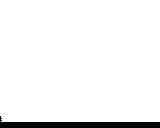

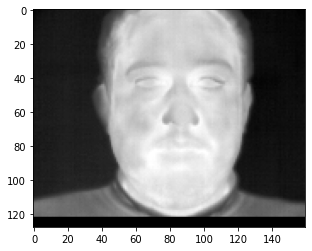

In [12]:
from matplotlib import pyplot
pyplot.imshow(X_train[7], cmap='gray')
display(Image.fromarray(X_train[1]*2000).convert('L'))

In [8]:
import tensorflow as tf

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
X_val = tf.keras.utils.normalize(X_val, axis=1)

In [17]:
print(X_train)
# Attempt at facial recognition

# import cv2
# HOME = os.getcwd()
# face_cascade = cv2.CascadeClassifier(os.path.join(HOME,'haarcascade_frontalface_alt2.xml'))

# img = X_train[0]*255
# img = np.array(img, dtype='uint8')

# # detect
# faces = face_cascade.detectMultiScale(img, minSize=(50,100), scaleFactor=1.05, minNeighbors=0, flags=cv2.CASCADE_SCALE_IMAGE)

# face_roi = None
# # draw boxes around ROI
# for (x,y,w,h) in faces:
#     face_roi = img[y:y+h,x:x+w]
#     cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 4)
    

# display(Image.fromarray(img))
# if face_roi:
#     display(Image.fromarray(face_roi))

[[[0.07656587 0.06818528 0.06271894 ... 0.07753238 0.07883577 0.06937728]
  [0.07103331 0.06928979 0.0707975  ... 0.08500345 0.08530833 0.07515585]
  [0.06627455 0.07433373 0.07446957 ... 0.08705559 0.07831797 0.07367681]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.03470824 0.03348328 0.01865076 ... 0.06448574 0.06448941 0.05404974]
  [0.02758668 0.03219806 0.04373505 ... 0.0663558  0.06706146 0.06034522]
  [0.01934066 0.03842122 0.04276027 ... 0.07003358 0.06452077 0.05995379]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.09233705 0.08471026 0.07801357 ... 0.07829648 0.07450699 0.06874748]
  [0.09364401 0.085609

In [18]:
# Shuffle X_train and y_train together
from sklearn.utils import shuffle

def shuffle_data(X, y):
    X_s, y_s = shuffle(X, y, random_state=42)
    return X_s, y_s

x,y = X_train.shape[1:]
# Get shuffled data and prepare for model.fit inputs
X_train_s, y_train_s = shuffle_data(X_train, y_train)
X_val_s, y_val_s = shuffle_data(X_val, y_val)
X_test_s, y_test_s = shuffle_data(X_test, y_test)
input_data = X_train_s.reshape((-1, x, y, 1))
val_data = X_val_s.reshape((-1, x, y, 1))
test_data = X_test_s.reshape((-1, x, y, 1))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6920 - accuracy: 0.7714


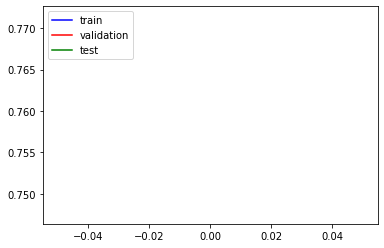

epoch 0, loss 0.692105, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 968us/sample - loss: 0.6909 - accuracy: 0.7714


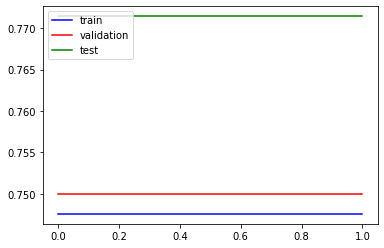

epoch 1, loss 0.691086, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6897 - accuracy: 0.7714


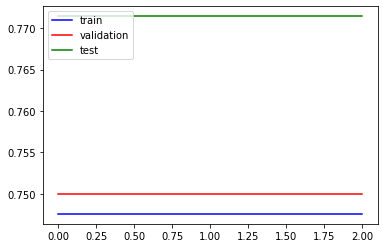

epoch 2, loss 0.690024, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 924us/sample - loss: 0.6885 - accuracy: 0.7714


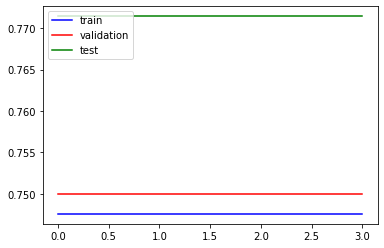

epoch 3, loss 0.688899, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 909us/sample - loss: 0.6875 - accuracy: 0.7714


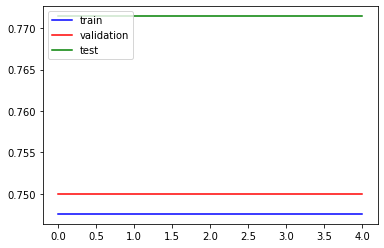

epoch 4, loss 0.687782, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6879 - accuracy: 0.7714


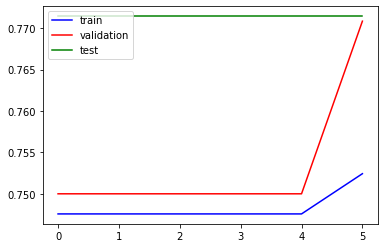

epoch 5, loss 0.687782, number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 947us/sample - loss: 0.6847 - accuracy: 0.7857


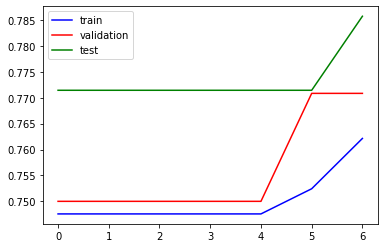

epoch 6, loss 0.685823, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 934us/sample - loss: 0.6824 - accuracy: 0.7714


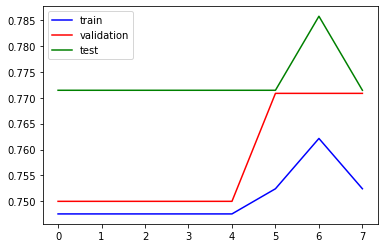

epoch 7, loss 0.682658, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6818 - accuracy: 0.7714


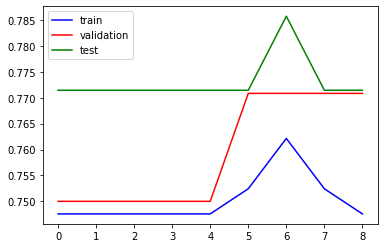

epoch 8, loss 0.682023, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 977us/sample - loss: 0.6825 - accuracy: 0.7857


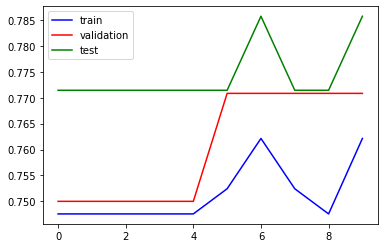

epoch 9, loss 0.682023, number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6818 - accuracy: 0.7857


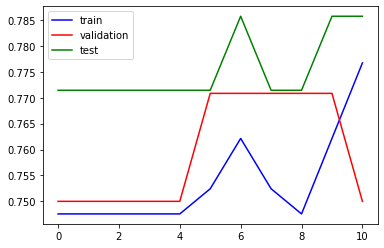

epoch 10, loss 0.682023, number 2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6796 - accuracy: 0.7857


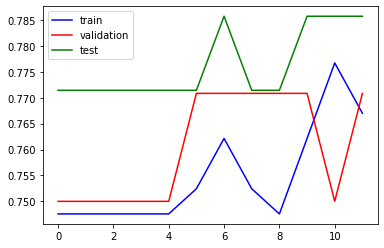

epoch 11, loss 0.681071, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6794 - accuracy: 0.7714


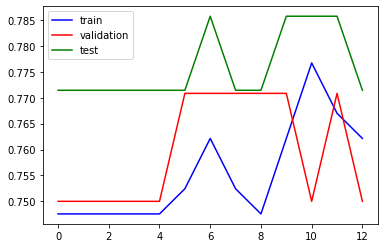

epoch 12, loss 0.680873, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 929us/sample - loss: 0.6782 - accuracy: 0.7714


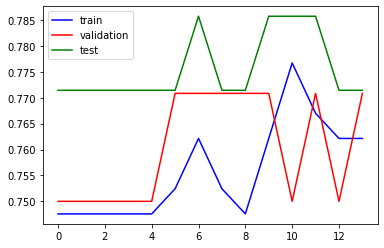

epoch 13, loss 0.679964, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 996us/sample - loss: 0.6734 - accuracy: 0.7714


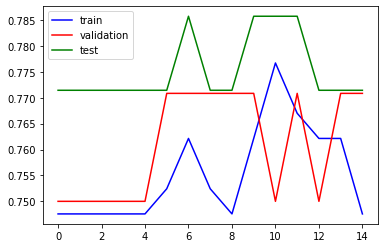

epoch 14, loss 0.674618, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 668us/sample - loss: 0.6717 - accuracy: 0.7714


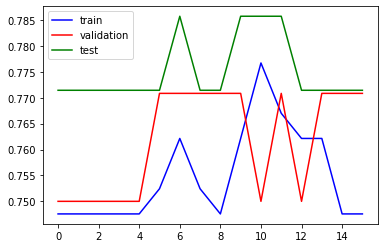

epoch 15, loss 0.673638, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 929us/sample - loss: 0.6763 - accuracy: 0.7714


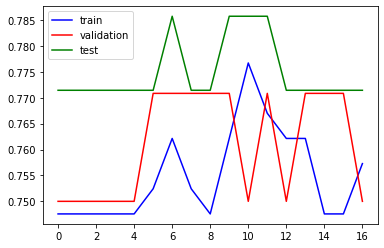

epoch 16, loss 0.673638, number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6727 - accuracy: 0.7714


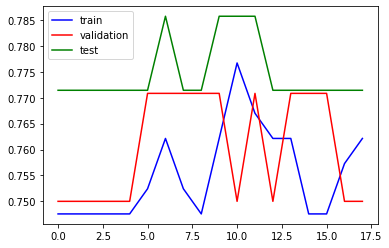

epoch 17, loss 0.673638, number 2
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6710 - accuracy: 0.7714


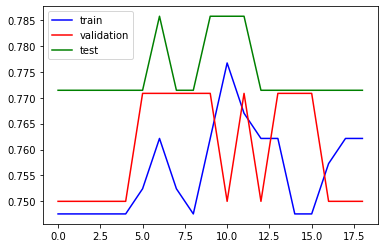

epoch 18, loss 0.672486, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6715 - accuracy: 0.7714


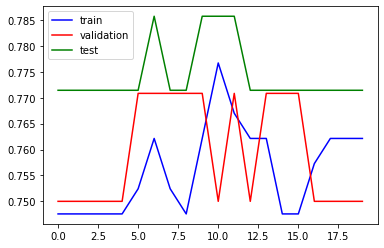

epoch 19, loss 0.672484, number 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
70/70 [==============================] - 0s 1ms/sample - loss: 0.6729 - accuracy: 0.7714


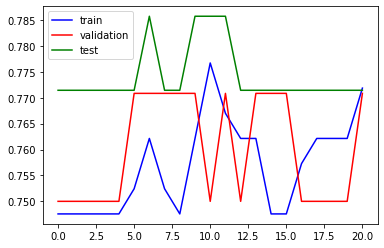

epoch 20, loss 0.672484, number 1
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 206 samples, validate on 48 samples
 96/206 [============>.................] - ETA: 0s - loss: 0.6553 - accuracy: 0.8281

KeyboardInterrupt: 

In [19]:
# Single CNN run

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import tensorflow.keras.metrics

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

x,y = X_train.shape[1:]
# Get shuffled data and prepare for model.fit inputs
X_train_s, y_train_s = shuffle_data(X_train, y_train)
X_val_s, y_val_s = shuffle_data(X_val, y_val)
X_test_s, y_test_s = shuffle_data(X_test, y_test)
input_data = X_train_s.reshape((-1, x, y, 1))
val_data = X_val_s.reshape((-1, x, y, 1))
test_data = X_test_s.reshape((-1, x, y, 1))

# 32, 64 works well on validation data
# 8. 16 also works well on validation data
# 8,32,32 works well on test data
## Model
model = Sequential()

model.add(Conv2D(2, (3, 3), input_shape=(x,y,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(2, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.add(Activation('sigmoid'))

##

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.BinaryCrossentropy(name='bce')
]

learning_rate = 0.00001
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])#, tensorflow.keras.metrics.Precision(name='precision')]) # Want to prevent false negatives (ie. predicting sober when actually drunk)

# Treat every sober image with same weight as 3 drunk images
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = {0: (1/4)/2, 1: (3/4)/2}

# how many epochs (passes through the data)
num_epochs = 1000

# this will hold the performance
perf_time = np.zeros((num_epochs, 4))

# set up figure
fig = plt.figure()
ax1 = fig.add_subplot(111)

# how well did it work?
best_val = [np.inf, 0]
for epoch in np.arange(0,num_epochs):
    # train an epoch at a time, visualize as we go!
    model.fit(input_data, np.array(y_train_s), 
              batch_size=2, 
              epochs=1, 
              verbose=1, 
              class_weight=class_weight,
              validation_data=(val_data,np.array(y_val_s)),
              shuffle=True,
              use_multiprocessing=True)    
    # check the performance on train/test/val
    # the model.evaluate function returns the loss (position 0) and the performance (position 1)
    val = model.evaluate(val_data, np.array(y_val_s))    
    new = [model.evaluate(input_data, np.array(y_train_s))[1],            
           val[0], val[1],            
           model.evaluate(test_data, np.array(y_test_s))[1]]    
    
    # add to performance
    perf_time[epoch,:]=new
    
    # visualize
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,0],'b', label='train')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,2],'r', label='validation')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,3],'g', label='test')
    plt.legend(loc='upper left')
    plt.show()
    
    # is validation performance better?
    if val[0] >= best_val[0]:
        best_val[1] += 1
    else:
        best_val = [val[0], 0]
    print ("epoch %d, loss %f, number %d" %(epoch, best_val[0], best_val[1]))
        
    # if there hasn't been an improvement in three epochs, stop training
    if best_val[1] > 30:
        break

In [ ]:
# Hyperparameter tuning for CNN where hyperparameters are layer sizes and batch size

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import tensorflow.keras.metrics


from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import itertools
import copy

np.random.seed(42)

# val scores from each run will be appended
# saved_acc = []
saved_acc = pickle.load(open('saved_acc.pkl', 'rb'))

# hyperparameters
layer1_size = [2,8,32,128]
layer2_size = [2,8,32,128]
layer3_size = [2,8,32,128]
layer4_size = [2,8,32,128]
batch_size = [2,8,32,128]

# creates a list of all combinations of hyperparameters
param_grid = list(itertools.product(layer1_size, layer2_size, layer3_size, layer4_size, batch_size))

offset = len(saved_acc)
for i, params in enumerate(param_grid[offset:]):
    i = i + offset
    # 32, 64 works well on validation data
    # 8. 16 also works well on validation data
    # 8,32,32 works well on test data
    ## Model
    model = Sequential()

    model.add(Conv2D(params[0], (3, 3), input_shape=(x,y,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    model.add(Dense(params[3], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1))

    model.add(Activation('sigmoid'))

    ##

    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
    METRICS = [
          tensorflow.keras.metrics.TruePositives(name='tp'),
          tensorflow.keras.metrics.FalsePositives(name='fp'),
          tensorflow.keras.metrics.TrueNegatives(name='tn'),
          tensorflow.keras.metrics.FalseNegatives(name='fn'), 
          tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
          tensorflow.keras.metrics.Precision(name='precision'),
          tensorflow.keras.metrics.Recall(name='recall'),
          tensorflow.keras.metrics.AUC(name='auc'),
          tensorflow.keras.metrics.BinaryCrossentropy(name='bce')
    ]

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])#, tensorflow.keras.metrics.Precision(name='precision')]) # Want to prevent false negatives (ie. predicting sober when actually drunk)

    # Treat every sober image with same weight as 3 drunk images
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
    class_weight = {0: (1/4)/2, 1: (3/4)/2}

    # how many epochs (passes through the data)
    num_epochs = 1000

    # this will hold the performance
    perf_time = np.zeros((num_epochs, 4))

    # set up figure
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # how well did it work?
    best_val = [np.inf, 0]
    for epoch in np.arange(0,num_epochs):
        # train an epoch at a time, visualize as we go!
        model.fit(input_data, np.array(y_train_s), 
                  batch_size=params[4], 
                  epochs=1, 
                  verbose=1, 
                  class_weight=class_weight,
                  validation_data=(val_data,np.array(y_val_s)),
                  shuffle=True,
                  use_multiprocessing=True)    
        # check the performance on train/test/val
        # the model.evaluate function returns the loss (position 0) and the performance (position 1)
        val = model.evaluate(val_data, np.array(y_val_s))  # val = [val_loss, val_accuracy]  
        new = [model.evaluate(input_data, np.array(y_train_s))[1],            
               val[0], val[1],            
               model.evaluate(test_data, np.array(y_test_s))[1]]    

        # add to performance
        perf_time[epoch,:]=new

        # visualize
        plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,0],'b', label='train')
        plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,2],'r', label='validation')
        plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,3],'g', label='test')
        plt.legend(loc='upper left')
        

        # is validation performance better?
        if val[0] >= best_val[0]:
            best_val[1] += 1
        else:
            best_val = [val[0], 0]
        print (f'hyperparameters {str(params)}, ' + "epoch %d, loss %f, number %d" %(epoch, best_val[0], best_val[1]))

        # if there hasn't been an improvement in three epochs, stop training
        if best_val[1] > 30:
            break
            
    test_accuracy = new[3]
    
    # set up figure
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    plt.title(f'Hyperparameters: {str(params)}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,0],'b', label='train')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,2],'r', label='validation')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,3],'g', label='test')
    plt.legend(loc='upper left')
    
    plt.savefig(f'run-{i}-{str(params)}-test_acc={test_accuracy}.png')
    
    plt.close('all') # close fig to save memory
    
    
    # save current model and val score
    save_model(model, f'run-{i}.hdf5')
    saved_acc.append(copy.deepcopy(test_accuracy))
    pickle.dump(saved_acc, open('saved_acc.pkl', 'wb'))

In [ ]:
best_index = np.argmax(saved_acc)

# best model found
model = load_model(f'run-{best_index}.hdf5')

print(f'Best hyperparameters:\t{param_grid[best_index]}')

In [ ]:
X_train.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import tensorflow.keras.metrics

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

x,y = X_train.shape[1:]
# Get shuffled data and prepare for model.fit inputs
X_train_s, y_train_s = shuffle_data(X_train, y_train)
X_val_s, y_val_s = shuffle_data(X_val, y_val)
X_test_s, y_test_s = shuffle_data(X_test, y_test)
input_data = X_train_s.reshape((-1, x, y, 1))
val_data = X_val_s.reshape((-1, x, y, 1))
test_data = X_test_s.reshape((-1, x, y, 1))

# 32, 64 works well on validation data
# 8. 16 also works well on validation data
## Model
model = Sequential()

model.add(Conv2D(8, (3, 3), input_shape=(x,y,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

model.add(Activation('sigmoid'))

##

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.BinaryCrossentropy(name='bce')
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# from tensorflow.keras.models import load_model
# model = load_model('256_save_best_tn2.epoch=24-val_tn=6.0000.hdf5')



# Treat every sober image with same weight as 3 drunk images
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = {0: (1/4)/2, 1: (3/4)/2}


save_best_model_loss = tf.keras.callbacks.ModelCheckpoint("best_loss2.epoch={epoch:02d}-val_loss={val_loss:.4f}.hdf5", 
                                                          monitor='val_loss', 
                                                          verbose=0, save_best_only=True, 
                                                          save_weights_only=False, 
                                                          mode='min', save_freq='epoch')
save_best_model_acc = tf.keras.callbacks.ModelCheckpoint("best_acc2.epoch={epoch:02d}-val_acc={val_accuracy:.4f}.hdf5", 
                                                         monitor='val_accuracy', 
                                                         verbose=0, save_best_only=True, 
                                                         save_weights_only=False, 
                                                         mode='max', save_freq='epoch')
# save_best_model_tn = tf.keras.callbacks.ModelCheckpoint("best_tn2.epoch={epoch:02d}-val_tn={val_tn:.4f}.hdf5", 
#                                                         monitor='val_tn',
#                                                         verbose=0, save_best_only=True, 
#                                                         save_weights_only=False, 
#                                                         mode='max', save_freq='epoch')
# save_best_model_auc = tf.keras.callbacks.ModelCheckpoint("best_auc2.epoch={epoch:02d}-val_auc={val_auc:.4f}.hdf5", 
#                                                         monitor='val_auc', 
#                                                         verbose=0, save_best_only=True, 
#                                                         save_weights_only=False, 
#                                                         mode='max', save_freq='epoch')
# save_best_model_bce = tf.keras.callbacks.ModelCheckpoint("best_bce2.epoch={epoch:02d}-val_bce={val_bce:.4f}.hdf5", 
#                                                         monitor='val_bce', 
#                                                         verbose=0, save_best_only=True, 
#                                                         save_weights_only=False, 
#                                                         mode='auto', save_freq='epoch')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=60,
    mode='max',
    restore_best_weights=False)

history = model.fit(input_data, np.array(y_train_s), 
          batch_size=128, 
          epochs=1000, 
          validation_data=(val_data,np.array(y_val_s)), 
          class_weight=class_weight,
          callbacks=[early_stopping,save_best_model_loss,save_best_model_acc],#,save_best_model_tn,save_best_model_auc,save_best_model_bce],
          shuffle=True,
          use_multiprocessing=True)


# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'],'--')
plt.title('Loss history (solid=val, solid=train)')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'],'--')
plt.title('Accuracy history (solid=val, solid=train)')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
# Manually load best saved model here and test
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
#model = load_model('best_acc2.epoch=55-val_acc=0.8750.hdf5')

X_test_s, y_test_s = shuffle_data(X_test, y_test)
test_data = X_test_s.reshape((-1, x, y, 1))
model.evaluate(test_data, np.array(y_test_s))

y_pred = model.predict_classes(test_data)

print(f'Accuracy: {accuracy_score(y_test_s,y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test_s,y_pred)}')

for i,(actual,pred) in enumerate(zip(y_test_s,y_pred)):
    print(f'Actual: {actual}, Pred: {pred}')
    
    if actual==0 and actual==pred:
        display(Image.fromarray(X_test_s[i]*1000).convert('L'))
        input('Enter for next true negative:')

In [24]:
# Determine if best model found's predictions are statistically significant vs guessing all drunk (77.14% accuracy)

from statsmodels.stats.anova import AnovaRM
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import tensorflow.keras.metrics

#best_index = np.argmax(saved_acc)
# best model found
model = load_model(f'../../best.hdf5')
#print(f'Best hyperparameters:\t{param_grid[best_index]}')


X_test_s, y_test_s = shuffle_data(X_test, y_test)
test_data = X_test_s.reshape((-1, x, y, 1))
model.evaluate(test_data, np.array(y_test_s))

y_pred = model.predict_classes(test_data)

subject = []
correct = []
model_name = []

for i, (true, pred) in enumerate(zip(y_test_s, y_pred)):
    subject.append(i)
    correct.append(int(true==pred))
    model_name.append('best')

# initialize y_pred where all predictions are drunk
y_pred_drunk = []
for _ in range(len(y_test_s)):
    y_pred_drunk.append(1) # TODO change this to whatever represents drunk
for i, (true, pred) in enumerate(zip(y_test_s, y_pred_drunk)):
    subject.append(i)
    correct.append(int(true==pred))
    model_name.append('all drunk')
    
anova_dict = {'Correct/Incorrect':correct,'Test_ID':subject,'Model_Name':model_name}
anova_df = pd.DataFrame(anova_dict)

anovarm = AnovaRM(data=anova_df, depvar='Correct/Incorrect', subject='Test_ID', within=['Model_Name'])
fit = anovarm.fit()
fit.summary()

70/70 [==============================] - 0s 3ms/sample - loss: 0.4024 - accuracy: 0.8429


,F Value,Num DF,Den DF,Pr > F
Model_Name,2.3154,1.0000,69.0000,0.1327


In [ ]:
display(Image.fromarray(X_test_s[0]*1000).convert('L'))